# Introducción

- Alumna: Abril Nazarena Rodriguez

- Legajo: R-4582/9

- Asignatura: Procesamiento de Imágenes y Visión por Computadora

El presente notebook consta de la resolución de los ejercicios 5 y 6 de la práctica de la unidad 1 de la materia.


# Librerías

In [2]:
!pip install -q mediapy
import mediapy as media
import cv2
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00


In [3]:
#Esto convierte el video a un formato más liviano de trabajo
!ffmpeg -y -i video_cv.mp4 -vf "scale=600:-1" -an -t 30 video_cv_600.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Ejercicio 5

El propósito de este ejercicio es realizar la detección de una persona en movimiento en un video capturado en un patio o hall de un edificio. Para ello, emplearé métodos de detección de movimiento sin recurrir al deep learning, con el objetivo de demostrar su utilidad en el contexto de la videovigilancia.

Luego, se aplicarán los algoritmos de flujo óptico (tanto denso como disperso) vistos en clase. Finalmente, realizaré una reflexión sobre los resultados obtenidos.

## Detección de movimiento con diferencia de fotogramas

En esta sección, detectaré el movimiento de la persona utilizando la técnica de **Frame Difference** (Diferencia de Fotogramas), la cual consiste en restar el cuadro actual del cuadro anterior en una secuencia de video, asumiendo que la cámara permanece estática.

De esta manera, se resaltan los píxeles que difieren entre las dos imágenes, intensificando aquellos que presentan una mayor diferencia.


Comenzaré cargando el video, capturado en el interior de mi casa, dentro de la variable 'video' y visualizándolo con el método 'show_video' de media.

In [4]:
video = media.read_video('video_cv_600.mp4')
media.show_video(video)

A continuación, definiré tres funciones que me serán de utilidad para procesar el video y lograr la detección de la persona.

- La función '**procesar_video**' toma como entrada un video, una función de procesamiento, un nombre para el video de salida y un tiempo máximo para procesar el video. Esta función genera un nuevo video, cuyo nombre se especifica mediante el parámetro '*filename_out*', luego de procesar el video de entrada '*filename_in*' utilizando la función de procesamiento proporcionada '*process_func*'. Por defecto, el parámetro que indica la duración máxima del video resultante '*max_time*' tiene un valor predeterminado de 10 segundos, pero puede modificarse según se desee.

- La función '**dibujar_contornos**' recibe un frame como entrada y, después de detectar los contornos en la imagen, devuelve la misma imagen con los bounding boxes dibujados en color verde alrededor de los contornos detectados.

- La función '**frame_difference**' toma como entrada un fotograma actual y un fotograma anterior, y devuelve la imagen resultante de la diferencia absoluta entre ambos fotogramas. El proceso llevado a cabo por esta función consiste en convertir ambos frames a escala de grises, calcular la diferencia entre ellos y normalizarla. Luego, se aplica una operación de dilatación utilizando un kernel de tamaño 5x5 para resaltar los contornos de manera más definida, aunque considero que en este caso no es tan necesario ya que se trata de una única persona en movimiento. Posteriormente, se identifican y dibujan los contornos encontrados en la imagen.


In [5]:
def procesar_video(filename_in, filename_out, process_func, max_time=10, **kwargs):
    '''Recibe un video y, luego de procesarlo con la función pasada por parámetro, devuelve el video resultante'''

    with media.VideoReader(filename_in) as r:    # abro el video de entrada para lectura

        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:  # Creo un archivo de video de salida
            count = 0  # contador de fotogramas
            prev_image = None  # imagen previa

            # itero sobre cada imagen (fotograma) del video
            for image in r:

                new_image = media.to_uint8(image)  # convierto la imagen a formato flotante

                if prev_image is None: prev_image = new_image.copy()   # compruebo si es la primera imagen

                processed_image = process_func(new_image, prev_image, **kwargs) # utilizando la función dada, proceso la imagen

                w.add_image(processed_image)   # añado la imagen procesada al video de salida

                prev_image = new_image.copy() # actualizo la imagen previa

                count += 1  # incremento el contador de fotogramas

                if count >= max_time * r.fps:   # cuando se alcance el tiempo máximo, detengo el proceso
                    break

In [6]:
def dibujar_contornos(frame, contours, color=(0, 255, 0), thickness=2):

    '''Esta función recibe un frame y dibuja los bounding boxes de los contornos encontrados en él'''

    # si la imagen está en escala de grises --> la convierto a color. Si no, hago una copia
    if len(frame.shape) == 2 or frame.shape[2] == 1: result_image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else: result_image = frame.copy()

    # para cada contorno encontrado, dibujo su bounding box
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, thickness)
    return result_image

In [8]:
def frame_difference(new_image, prev_image, **kwargs):
    '''Recibe un frame actual y el anterior y luego de calcular su diferencia absoluta, normalizarla,
    umbralizarla y dilatarla, dibuja los contornos encontrados'''

    # convierto el frame anterior y el actual a escala de grises
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    frame_diff = cv2.absdiff(new_gray, prev_gray)  # calculo diferencia absoluta entre ambos fotogramas

    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)  # normalizo la imagen de diferencia

    _, thresh = cv2.threshold(norm_diff, 30, 255, cv2.THRESH_BINARY)  # umbralizo la imagen de diferencia

    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)     # dilato la imagen umbralizada con un kernel de 5x5

    dilated = dilated.astype(np.uint8)   # convierto la imagen dilatada a formato adecuado para findContours

    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   # encuentro contornos en la imagen dilatada

    if kwargs.get('draw_mode', 0) == 0:
      result_image = dibujar_contornos(new_image, contours)   # si draw_mode = 0 --> dibujo los bounding boxes sobre la imagen a color
    elif kwargs.get('draw_mode', 0) == 1:
      result_image = dibujar_contornos(thresh, contours)   # si draw_mode = 1 --> dibujo los bounding boxes sobre la iamgen binarizada

    return result_image

Una vez que he definido las funciones necesarias, procedo a establecer los nombres del video de entrada y salida. Luego, llamo a la función '**procesar_video**', pasándole dichos parámetros junto con la función '**frame_difference**', que se encarga de calcular la diferencia entre frames consecutivos para detectar movimiento.

Como me interesa visualizar los resultados tanto en el video a color como en el video umbralizado, llamaré a la función dos veces, variando el valor del parámetro '*draw_mode*'.

In [9]:
filename_in = 'video_cv_600.mp4'        # video de entrada
filename_out = 'video_cv_frame_diff.mp4'  # nombre del video de salida

# llamo a la función y muestro el video umbralizado

procesar_video(filename_in, filename_out, frame_difference,
                max_time=10, draw_mode=1)

media.show_video(media.read_video(filename_out), fps=30)

# llamo a la función y muestro el video a color

filename_out = 'video_cv_frame_diff_2.mp4'
procesar_video(filename_in, filename_out, frame_difference,
                max_time=10, draw_mode=0)

media.show_video(media.read_video(filename_out), fps=30)

Si bien ha detectado bien a la persona en movimiento, se observa muchísimo ruido en el video. Para mejorar los resultados, se podrían filtrar los contornos encontrados según su aspecto y área, para que se asemejen al formato de una persona.

## Flujo óptico disperso

En esta sección, aplicaré el algoritmo de flujo óptico disperso visto en clase, en donde se detecta el movimiento de objetos entre cuadros consecutivos de una secuencia, calculando el flujo óptico solo para una pequeña cantidad de píxeles de una imagen, los cuales suelen ser puntos de interés, como bordes u objetos reconocibles.

In [26]:
def optico_disperso(new_image, prev_image):
    '''Recibe un frame actual y uno anterior y, luego de calcular el flujo óptico disperso,
    devuelve la imagen con el movimiento dibujado '''
    # convierto frame actual y anterior a blanco y negro
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    prev_gray_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)

    # Verifico si ya se han detectado las características de Shi-Tomasi
    if not hasattr(optico_disperso, "shi_tomasi_done"):

        feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7) # defino parámetros para la detección de esquinas de Shi-Tomasi

        optico_disperso.prev_points = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params) # detecto puntos característicos en la imagen

        optico_disperso.mask = np.zeros_like(new_image) # creo una máscara para dibujar el flujo óptico

        optico_disperso.shi_tomasi_done = True   # marco que se ha completado la detección de Shi-Tomasi

    # Continuar si se ha completado la detección de Shi-Tomasi
    if optico_disperso.shi_tomasi_done:
        prev_points = optico_disperso.prev_points
        mask = optico_disperso.mask

    # defino parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # calculo el flujo óptico de Lucas-Kanade
    new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # filtro puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # color para el dibujo
    # dibujo el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        new_image = cv2.circle(new_image, (a, b), 3, color, -1)


    output = cv2.add(new_image, mask) # combino la imagen actual con las líneas de flujo óptico dibujadas

    optico_disperso.prev_points = good_new.reshape(-1, 1, 2) # actualizo puntos para el siguiente cuadro
    return output

Una vez definida la función para calcular el flujo óptico disperso, defino el video de entrada y el nombre del video de salida, y llamo a la función '**procesar_video**'.

In [27]:
filename_in = 'video_cv_600.mp4'   # video de entrada
filename_out = 'video_cv_optico_disperso.mp4' # nombre video de salida

# llamo a la función para procesar el video y muestro el resultado
procesar_video(filename_in, filename_out, optico_disperso, max_time=10)

media.show_video(media.read_video(filename_out), fps=30)

## Flujo óptico denso

Finalmente, aplicaré un algotimo de flujo óptico denso, el cual ofrece los vectores de flujo de todo el cuadro.

In [28]:
def optico_denso(new_image, prev_image):
    '''Recibe un frame actual y el anterior y procesa el flujo óptico denso, devolviendo
    la imagen con el movimiento'''

    gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY) # convierto imagen a grises

    if not hasattr(optico_denso, "init_done"):
        optico_denso.prev_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        optico_denso.mask = np.zeros_like(new_image)
        optico_denso.mask[..., 1] = 255
        optico_denso.init_done = True

    if optico_denso.init_done:
        prev_gray = optico_denso.prev_gray
        mask = optico_denso.mask

    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)  # calcula flujo óptico

    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])  # magnitud y ángulo de los vectores

    mask[..., 0] = angle * 180 / np.pi / 2  # tono de la imagen según la dirección del flujo óptico

    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)   # valor de la imagen según la magnitud del flujo óptico

    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)   # convierto de HSV a RGB

    optico_denso.prev_grayprev_gray = gray.copy()  # actualizo imagen previa a gris

    return rgb

A continuación, defino el nombre para el video de salida, llamo a la función que procesa el flujo óptico denso y visualizo los resultados.

In [29]:
# llamo a la función y muestro el resultado

procesar_video('video_cv_600.mp4', 'video_cv_optico_denso.mp4', optico_denso,
                max_time=20)

media.show_video(media.read_video('video_cv_optico_denso.mp4'), fps=30)

## Reflexiones

Luego de aplicar los tres algoritmos de detección de movimiento al video que grabé de una persona caminando en un ambiente de mi casa, relataré las conclusiones a las que llegué.

En primer lugar, el algoritmo basado en la diferencia entre fotogramas resulta bastante inestable. Si bien logra detectar correctamente el movimiento de la persona, también genera muchísimo ruido, como se evidencia con la aparición de numerosos bounding boxes adicionales. Además, este algoritmo tiende a detectar la sombra de la persona, lo cual no resulta relevante. Tal vez, filtrando algunos bounding boxes, quedándonos solo con aquellos que cumplan con un aspecto y área determinados, se puedan obtener resultados más precisos.

Por otro lado, el algoritmo de flujo óptico disperso muestra mejores resultados. En este caso, se observan pocos errores y se detecta adecuadamente el movimiento de la persona.

Finalmente, el algoritmo de flujo óptico denso presenta algunas limitaciones, como la detección de partes del fondo como si estuvieran en movimiento, lo cual es incorrecto. Sin embargo, cuando la persona está presente en la escena, este algoritmo sigue correctamente su movimiento.

En cuanto a los tiempos de ejecución, es evidente que el algoritmo que más recursos consume es el de flujo óptico denso, debido a su cálculo para cada píxel en cada fotograma.

En conclusión, para este video en específico, el algoritmo de flujo óptico disperso es el que mejor detecta el movimiento, ya que muestra menos ruido y permite observar claramente el movimiento de la persona. Aunque los otros algoritmos también logran detectar el movimiento de la persona, se ven afectados por el ruido de fondo. Es posible que, al grabar el video en un entorno con un fondo más uniforme, se obtengan resultados aún mejores.

# Ejercicio 6

El objetivo de este ejercicio es explicar la diferencia entre la localización de objetos y la clasificación de imágenes, mostrando ejemplos.

Ambos conceptos suelen ser objeto de confusión y, si bien son problemas que trata de resolver el procesamiento de imágenes, tienen dos enfoques distintos.

Mientras que la clasificación de imágenes consiste únicamente en etiquetar el contenido de una imagen, la localización de imágenes es una técnica que tiene como objetivo identificar y ubicar la posición de objetos en imágenes o vídeos. Es decir, a diferencia de lo primero, no se limita a decir qué hay en la foto, sino dónde se encuentra el objeto de interés.

Un ejemplo bastante común de localización de objetos es el sistema de detección facial en cámaras de teléfonos celulares, que identifica los rostros de las personas y delimita su ubicación, con el fin de evitar el desenfoque de la imagen. Otro ejemplo es el uso de algoritmos de localización de objetos en sistemas de conducción autónoma, donde se detectan y se clasifican elementos del entorno, como peatones y señales de tráfico, para tomar decisiones adecuadas.

En cuanto a su funcionamiento, la localización de objetos se basa en algoritmos y técnicas que permiten detectar características distintivas de los objetos, como contornos, texturas o colores.

A continuación se muestra, a modo de ejemplo, una imagen donde se localizan distintos objetos. Aquí, además de identificarlos mediante un bounding box, aclara de qué objeto se trata.

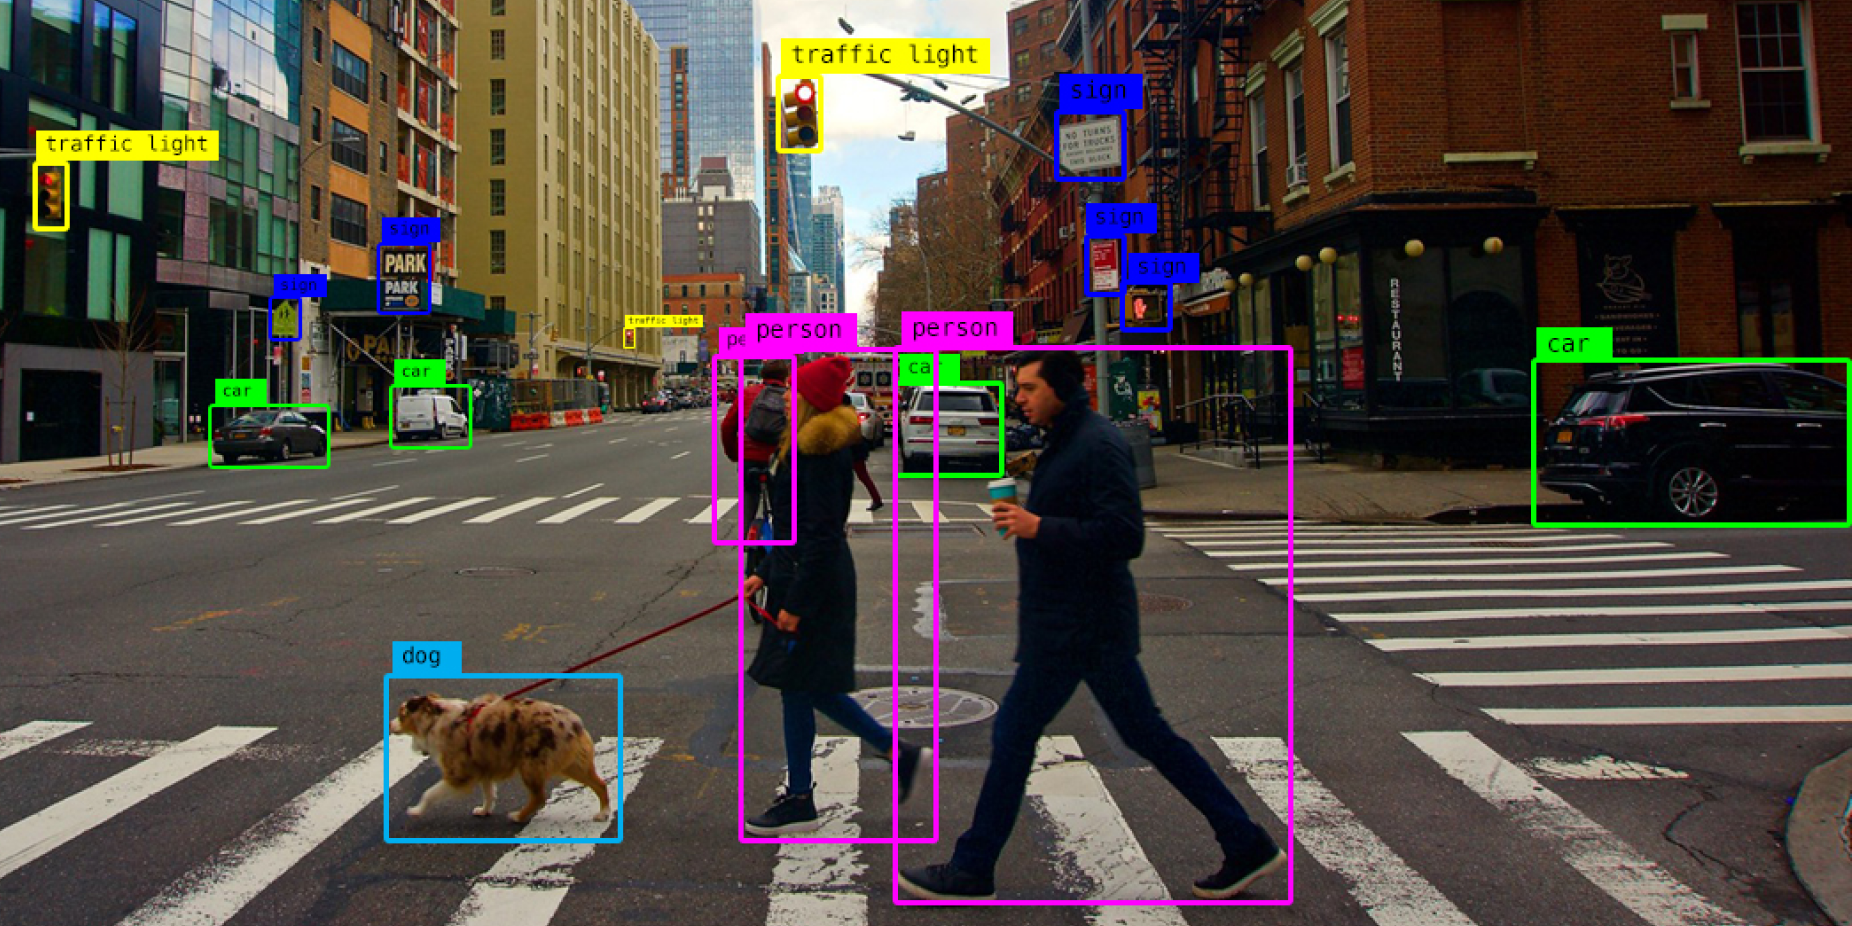




Por otro lado, la clasificación de imágenes consiste en analizar una imagen de entrada y devolver una etiqueta que categorice la imagen. La etiqueta es siempre de un conjunto predefinido de posibles categorías.

Estos algoritmos se utilizan, por ejemplo, en el reconocimiento facial o en el diagnóstico médico.

A continuación, se presenta una imagen como ejemplo. Utilizando un algoritmo de detección de objetos se determinó, con un 82% de certeza, que podría tratarse de un gato.

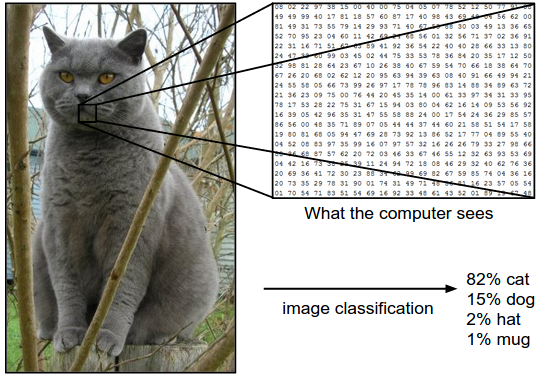


En conclusión, la clasificación de imágenes y la localización de objetos son dos enfoques diferentes en el procesamiento de imágenes, cada uno con sus propias aplicaciones y métodos específicos. Mientras la clasificación de imágenes asigna etiquetas a imágenes completas, la localización de objetos identifica la presencia y la posición de objetos específicos dentro de una imagen.
